### CosmoBench Dataset Tutorial
This notebook gives an overview of the datasets and tasks. Specifically:
- Point cloud datasets: CAMELS (1k clouds, 588-4511 points per cloud)
  - Task 1: Predicting cosmological parameters from point positions
  - Task 2: Predicting velocities from positions
- Merger tree datasets: CS-Trees (25k trees, 121-37865 nodes per tree); infilling-Trees (coarsened trees from the 200 largest CS-Trees)
  - Task 3: Predicing cosmological parameters from merger trees
  - Task 4: Reconstructing fine-grained trees from coarsened trees

In [1]:
import os 
import subprocess
import torch 
import numpy as np
import math
import argparse
import pathlib
import h5py
import time
import matplotlib.pyplot as plt
import pickle
import json
from itertools import product

from models.cloud_param.simple_param import load_position_h5
from models.cloud_velocity.simple_velocity import load_point_cloud_h5

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

### Point cloud datasets
- Quijote download url: https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/Quijote/
- CAMELS-SAM download url: https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS-SAM/galaxies/
- CAMELS download url: https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS/
- Store the downloaded data in `DATA_DIR`. 

For demo purpose, we will download CAMELS (the smallest point cloud dataset) on-the-fly, exploring the point clouds as well as running some simple baselines

#### Data exploration

In [ ]:
data_dir = "CosmoBench_CAMELS"
os.makedirs(data_dir, exist_ok=True)

url = "https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS/"
pattern = "ALL_galaxies_*.hdf5" #only download the point cloud data (excluding the precomputed 2PCF)

cmd = [
    "wget", "-r", "-l1", "-nd", "-A", pattern,
    "-P", data_dir, url
]
subprocess.run(cmd)

After downloading, `DATA_DIR` should contain the train/val/test splits of CAMELS point clouds, in the form `ALL_galaxies_*.hdf5` 

We can read the point clouds from the H5 files as follows

In [2]:
#specify the h5 file dataset group key
data_dir = "CosmoBench_CAMELS"

if "Quijote" in data_dir:
    grp_key = "BSQ"
elif "CAMELS" in data_dir:
    grp_key = "LH"
#train/val/test files
h5_train = f"{data_dir}/ALL_galaxies_train.hdf5"
h5_val = f"{data_dir}/ALL_galaxies_val.hdf5"
h5_test = f"{data_dir}/ALL_galaxies_test.hdf5"

idx = 0
x,y,z = load_position_h5(h5_train, idx=idx, data_name=grp_key, device="cpu")
x,y,z,vx,vy,vz = load_point_cloud_h5(h5_train, idx=idx, data_name=grp_key, device='cpu')

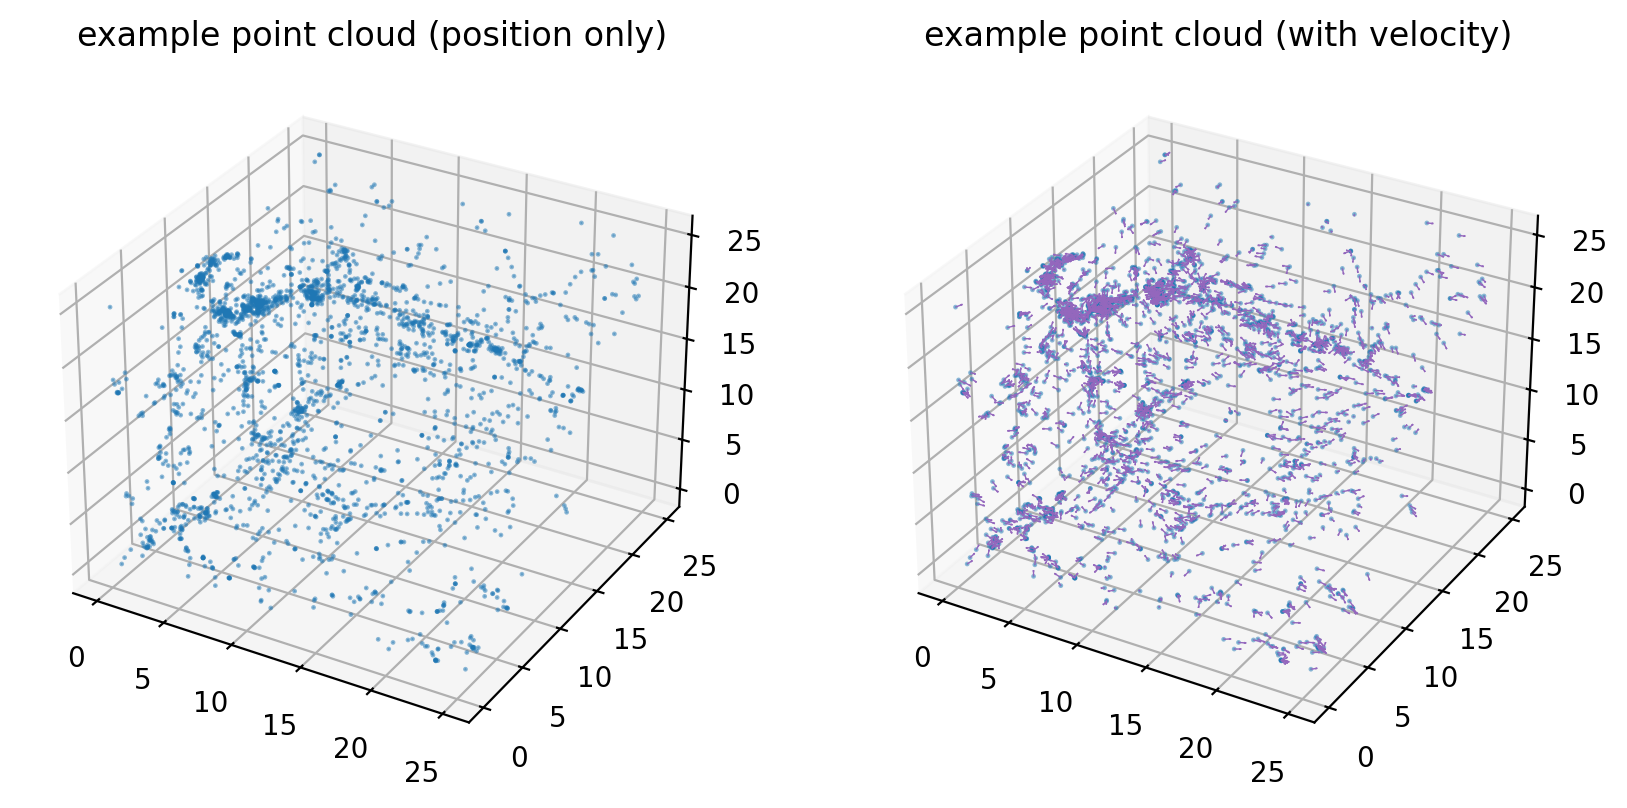

In [4]:
fig = plt.figure(figsize=(10,10), dpi=200)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(x,y,z, color='tab:blue', s=0.5, alpha=0.5)
ax2.scatter(x,y,z, color='tab:blue', s=0.5, alpha=0.5)
ax2.quiver(x,y,z,vx,vy,vz, length=0.5, normalize=True, color='tab:purple', linewidth=0.5)

ax1.set_title('example point cloud (position only)')
ax2.set_title('example point cloud (with velocity)')

plt.show()

#### Task 1: Predicting cosmological params from point positions
- Baseline: linear least squares on pairwise-distance (truncated at Rc) statistics

In [3]:
from models.cloud_param.simple_param import Rc_dict_om, Rc_dict_s8, \
    compute_h5_features, load_param_h5, fit_least_squares, compute_R2, bootstrap_r2

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
prefix = "CAMELS-TNG" #['Quijote', 'CAMELS-SAM']
n_train, n_val, n_test, period = 600, 200, 200, 25 
Rc = Rc_dict_om[prefix]

In [5]:
#this can take a few minutes...please be patient
X_train, _ = compute_h5_features(h5_train, grp_key, 
                                n_train, Rc, period, device)
X_test, _ = compute_h5_features(h5_test, grp_key, 
                                n_test, Rc, period, device)

In [8]:
X_train = X_train.flatten(start_dim=0, end_dim=1)
X_train = X_train.to(device) #shape (4*12, n_cloud_train)

X_test = X_test.flatten(start_dim=0, end_dim=1) 
X_test = X_test.to(device)  #shape (4*12, n_cloud_test)

#load labels 
target_name = 'om' #'s8'
Y_train = load_param_h5(h5_train, target_name, device=device)
Y_test = load_param_h5(h5_test, target_name, device=device)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([48, 600]) torch.Size([600]) torch.Size([48, 200]) torch.Size([200])


In [9]:
w, b = fit_least_squares(X_train, Y_train)
#pred: clip into the range
lim = Rc_dict_om['limits'] #Rc_dict_s8['limits']
Y_pred_train = torch.clamp( w @ X_train + b , min=lim[0], max=lim[1])
Y_pred_test = torch.clamp( w @ X_test + b , min=lim[0], max=lim[1])

#Compute metrics
R2_train = compute_R2(Y_pred_train, Y_train)
R2_test = compute_R2(Y_pred_test, Y_test)
R2_boot, R2_boot_std = bootstrap_r2(Y_pred_test, Y_test )

print(f"{prefix} on {target_name}: R2_train={R2_train:.4f}, R2_test={R2_test:.4f}, R2_boot_std={R2_boot_std:.4f}")


CAMELS-TNG on om: R2_train=0.8567, R2_test=0.7886, R2_boot_std=0.0269


#### Task 2: Predicting velocities from positions
- Baseline: linear least squares on powers of inverse distances

In [10]:
from models.cloud_velocity.simple_velocity import compute_invPwrLaw_features

In [11]:
#Feature Order and init matrices for linear least square fit
K, P = 10, 3
A = torch.zeros((K*P, K*P)).to(device)
b = torch.zeros((K*P,1)).to(device)

In [12]:
idxTrain = range(0, n_train)
idxTest = range(0, n_test)

for t in idxTrain:
    x,y,z,vx,vy,vz = load_point_cloud_h5(h5_train, t, grp_key) #each is a (n,1) vector or (1,n) ? CHECK
    Fx = compute_invPwrLaw_features(x,y,z,K,P, period, device) #(d, n)
    Fy = compute_invPwrLaw_features(y,z,x,K,P, period, device)
    Fz = compute_invPwrLaw_features(z,x,y,K,P, period, device)
    A = A + Fx @ Fx.T + Fy @ Fy.T + Fz @ Fz.T #(d,d)
    b = b + Fx @ vx.unsqueeze(1) + Fy @ vy.unsqueeze(1) + Fz @ vz.unsqueeze(1)  #(d,1)

w = torch.linalg.lstsq(A, b).solution #(d,1)

In [13]:
R2_all = []
for idx in idxTest:
    x,y,z,vx,vy,vz = load_point_cloud_h5(h5_test, idx, grp_key) 
    Fx = compute_invPwrLaw_features(x,y,z,K,P, period, device) #(d, n)
    Fy = compute_invPwrLaw_features(y,z,x,K,P, period, device)
    Fz = compute_invPwrLaw_features(z,x,y,K,P, period, device)
    #feat_time = time.time()
    F_xyz =  torch.stack([Fx, Fy, Fz], dim=0)  # shape: (3, d, n)
    v_pred = torch.einsum('d,cdn->cn', w.squeeze(), F_xyz).T  # shape: (n, 3)
    v_target = torch.stack([vx, vy, vz], dim=-1)
    R2 = compute_R2(v_pred, v_target)
    R2_all.append(R2)
R2_mean = sum(R2_all)/len(R2_all)

print(f"test set R2={R2_mean:.4f}")

test set R2=0.2695


### Merger tree datasets
- Data download url: https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS-SAM/trees/
- Store the downloaded data in `TREE_DIR`

For demo purpose, we only download `CS_tree_train.pt`,`CS_tree_val.pt` and `infilling_trees_25k_200_val.pt`

In [14]:
from models.tree_param.model_tree import TreeRegressor, MLPAgg, DeepSet, train_eval_model
from utils.tree_util import dataset_to_dataloader
from torch_geometric.utils import to_networkx

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

Pytorch Geometric is available = True. Return list of PyG.Data = True


In [15]:
tree_dir = "CosmoBench_Trees"
os.makedirs(tree_dir, exist_ok=True)

url = "https://users.flatironinstitute.org/~fvillaescusa/CosmoBench/CAMELS-SAM/trees/"
file_names = ['CS_tree_train.pt', 'CS_tree_val.pt', \
              'infilling_trees_25k_200_train.pt', 'infilling_trees_25k_200_val.pt']

for fname in file_names:
    full_url = url + fname
    print(f"Downloading {fname}...")
    subprocess.run(['wget', '-q', '-P', tree_dir, full_url])

In [16]:
def plot_tree(data):
    G = to_networkx(data, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    fig, ax = plt.subplots(dpi=200)
    
    mask_main = torch.isin(data.node_halo_id.flatten(), torch.LongTensor(data.mask_main)) #NOTE: a halo id may appear > 1 if the halo splits
    node_indices = torch.nonzero(mask_main).flatten()

    node_colors = ["tab:pink" if n in node_indices else "skyblue" for n in G.nodes()]
    
    nx.draw(G, pos=pos, with_labels=False, arrows=True, arrowsize=1,
            ax=ax, node_color=node_colors, node_size=3)

In [17]:
tree_dir = "CosmoBench_Trees"

trainset_path = f"{tree_dir}/CS_tree_train.pt"
valset_path = f"{tree_dir}/CS_tree_val.pt"
trainset = torch.load(trainset_path) #a list of PyG Data storing node features, edge index, etc
valset = torch.load(valset_path) #a list of PyG Data storing node features, edge index, etc


/tmp/ipykernel_452227/2636837194.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


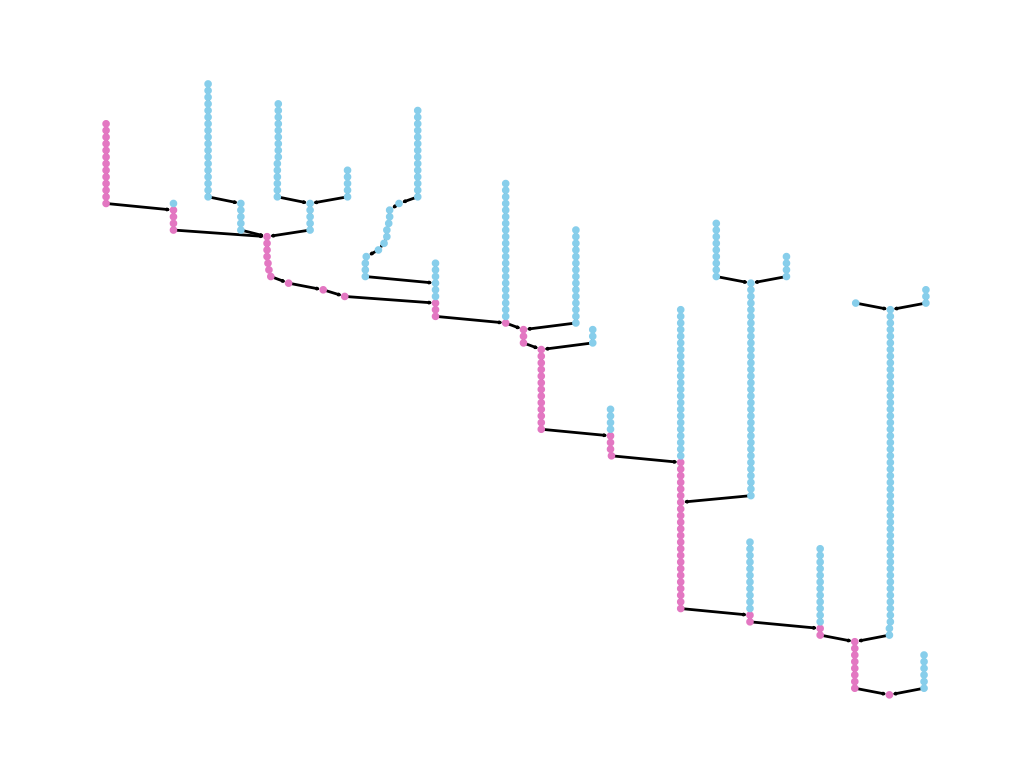

In [18]:
#the pink dots denoting the main branch of the merger tree
sample_tree = trainset[0]
plot_tree(sample_tree)

#### Task 3: Predicting cosmological parameters from merger trees
- Baseline: message-passing graph neural network (MPNN)

In [19]:
### full dataset with n_samples = 25

batch_size = 128
feat_idx = [0,1,2,3] #(Mass, concentration, vmax, scale)
train_loader, val_loader, test_loader = dataset_to_dataloader(trainset, valset, None,
                                                                batch_size=batch_size,
                                                        normalize=True, feat_idx=feat_idx)


normalizing for mean 0 , std 1 across all trees!
train_size=14997, val_size=5099, test_size=0
sampled train data view = Data(x=[363, 4], edge_index=[2, 362], edge_attr=[362, 1], y=[1, 2], num_nodes=363, lh_id=0, mask_main=[94], node_halo_id=[363, 1])


/mnt/home/thuang/playground/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [20]:
#initialize MPNN model
device = "cuda" if torch.cuda.is_available() else "cpu"
node_dim = len(feat_idx)
hid_dim = 16
out_dim = 2
n_layer = 5
model = TreeRegressor(node_dim, hid_dim, out_dim, n_layer, loop_flag=True)
model = model.float() #ensure using float32
model = model.to(device)


In [21]:
num_epochs = 10
lr = 5e-3
train_loss_steps, val_loss_eps = train_eval_model(model, train_loader, val_loader, 
                                                mlp_only=False, n_epochs=num_epochs,
                                                lr=lr, target_id=None)

epoch=0, train_loss=0.0219, val_loss=0.0169, R2_om=0.3614, R2_s8=0.2987
epoch=1, train_loss=0.0077, val_loss=0.0137, R2_om=0.7316, R2_s8=0.1965
epoch=2, train_loss=0.0065, val_loss=0.0104, R2_om=0.8418, R2_s8=0.3503
epoch=3, train_loss=0.0042, val_loss=0.0063, R2_om=0.9486, R2_s8=0.5681
epoch=4, train_loss=0.0028, val_loss=0.0052, R2_om=0.9628, R2_s8=0.6357
epoch=5, train_loss=0.0022, val_loss=0.0038, R2_om=0.9870, R2_s8=0.7244
epoch=6, train_loss=0.0021, val_loss=0.0058, R2_om=0.9382, R2_s8=0.6144
epoch=7, train_loss=0.0020, val_loss=0.0046, R2_om=0.9506, R2_s8=0.6956
epoch=8, train_loss=0.0018, val_loss=0.0041, R2_om=0.9293, R2_s8=0.7547
epoch=9, train_loss=0.0018, val_loss=0.0031, R2_om=0.9886, R2_s8=0.7733


#### Task 4: Reconstructing fine-grained merger trees via node classification
- Baseline: MPNN (classifying the augmented virtual nodes in the coarsened tree)

In [22]:
from models.tree_recon.model_infilling import TreeNodeClassifier, train_eval_classifier, eval_classifier
from utils.tree_util import subset_data_features

In [23]:
train_path = f"{tree_dir}/infilling_trees_25k_200_train.pt"
val_path = f"{tree_dir}/infilling_trees_25k_200_val.pt"

train_trees =  subset_data_features(torch.load(train_path), feat_idx)
val_trees = subset_data_features(torch.load(val_path), feat_idx)
   

In [24]:
out_dim = 2 #binary classification
node_dim = len(feat_idx) #input feature dim
model = TreeNodeClassifier(node_dim, hid_dim, out_dim, n_layer=4, loop_flag=True)
model = model.float()
model = model.to(device)


In [25]:
train_loss, val_loss_out, best_val_acc = train_eval_classifier(model, train_trees, val_trees, save_dir=tree_dir, 
                                                               num_epochs=num_epochs, lr=1e-3)


Epoch 0, Train Loss: 0.6470; Val Loss Hold-Out: 0.6456, Val Acc. Hold-Out: 0.6135
